# Learning to learn with quantum neural networks¶
Stefano Mangini
Stefano Mangini
Published March 2, 2021. Last updated August 28, 2023.

In this demo we recreate the architecture proposed in Learning to learn with quantum neural networks via classical neural networks 1, using PennyLane and TensorFlow. We use classical recurrent neural networks to assist the optimization of variational quantum algorithms.

We start with a brief theoretical overview explaining the problem and the setup used to solve it. After that, we deep dive into the code to build a fully functioning model, ready to be further developed or customized for your own needs. Without further ado, let’s begin!



# Problem: Optimization of Variational Quantum Algorithms
Recently, a big effort by the quantum computing community has been devoted to the study of variational quantum algorithms (VQAs) which leverage quantum circuits with fixed shape and tunable parameters. The idea is similar to classical neural networks, where the weights of the network are optimized during training. Similarly, once the shape of the variational quantum circuit is chosen — something that is very difficult and sensitive to the particular task at hand — its tunable parameters are optimized iteratively by minimizing a cost (or loss) function, which measures how good the quantum algorithm is performing (see 2 for a thorough overview on VQAs).

A major challenge for VQAs relates to the optimization of tunable parameters, which was shown to be a very hard task 3, 2 . Parameter initialization plays a key role in this scenario, since initializing the parameters in the proximity of an optimal solution leads to faster convergence and better results. Thus, a good initialization strategy is crucial to promote the convergence of local optimizers to local extrema and to select reasonably good local minima. By local optimizer, we mean a procedure that moves from one solution to another by small (local) changes in parameter space. These are opposed to global search methods, which take into account large sections of parameter space to propose a new solution.

One such strategy could come from the classical machine learning literature.



![Alt text](image-1.png)

In [10]:
#Quantum Machine Learning
import pennylane as qml
from pennylane import qaoa

# Classical Machine Learning
import tensorflow as tf

# Generation of graphs
import networkx as nx

# Standard Python libraries
import numpy as np
import matplotlib.pyplot as plt
import random

ModuleNotFoundError: No module named 'pennylane'

In [2]:
import matplotlib.pyplot as plt
import random
# Fix the seed for reproducibility, which affects all random functions in this demo
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

Generation of training data: graphs
The first step is to gather or create a good dataset that will be used to train the model and test its performance. In our case, we are analyzing MaxCut, which deals with the problem of finding a good binary partition of nodes in a graph such that the number of edges cut by such a separation is maximized. We start by generating some random graphs  
$ G_{n,p} $
where:
n is the number of nodes in each graph,
p is the probability of having an edge between two nodes.

In [3]:
def generate_graphs(n_graphs, n_nodes, p_edge):
    """Generate a list containing random graphs generated by Networkx."""

    datapoints = []
    for _ in range(n_graphs):
        random_graph = nx.gnp_random_graph(n_nodes, p=p_edge)
        datapoints.append(random_graph)
    return datapoints

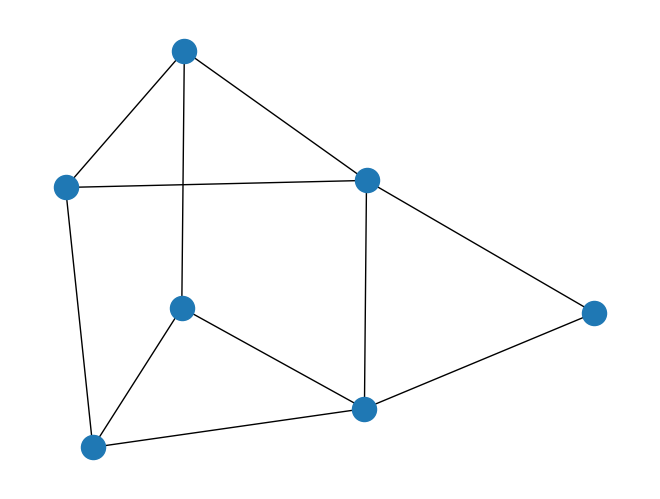

In [4]:
# An example of a random graph generated using the function generate_graphs just defined:
# Define parameters of the graphs
n_graphs = 20
n_nodes = 7
p_edge = 3.0 / n_nodes
graphs = generate_graphs(n_graphs, n_nodes, p_edge)

nx.draw(graphs[0])

# Variational Quantum Circuit: QAOA
Now that we have a dataset, we move on by creating the QAOA quantum circuits using PennyLane’s built-in sub-packages. In particular, using PennyLane’s qaoa module, we will able to create fully functioning quantum circuits for the MaxCut problem, with very few lines of code.

In [6]:
def qaoa_from_graph(graph, n_layers=1):
    """Uses QAOA to create a cost Hamiltonian for the MaxCut problem."""

    # Number of qubits (wires) equal to the number of nodes in the graph
    wires = range(len(graph.nodes))

    # Define the structure of the cost and mixer subcircuits for the MaxCut problem
    cost_h, mixer_h = qaoa.maxcut(graph)

    # Defines a layer of the QAOA ansatz from the cost and mixer Hamiltonians
    def qaoa_layer(gamma, alpha):
        qaoa.cost_layer(gamma, cost_h)
        qaoa.mixer_layer(alpha, mixer_h)

    # Creates the actual quantum circuit for the QAOA algorithm
    def circuit(params, **kwargs):
        for w in wires:
            qml.Hadamard(wires=w)
        qml.layer(qaoa_layer, n_layers, params[0], params[1])
        return qml.expval(cost_h)

    # Evaluates the cost Hamiltonian
    def hamiltonian(params, **kwargs):
        """Evaluate the cost Hamiltonian, given the angles and the graph."""

        # We set the default.qubit.tf device for seamless integration with TensorFlow
        dev = qml.device("default.qubit.tf", wires=len(graph.nodes))

        # This qnode evaluates the expectation value of the cost hamiltonian operator
        cost = qml.QNode(circuit, dev, interface="tf", diff_method="backprop")

        return cost(params)

    return hamiltonian


# Create an instance of a QAOA cir

In [7]:
#Before continuing, let’s see how to use these functions.

# Create an instance of a QAOA circuit given a graph.
cost = qaoa_from_graph(graph=graphs[0], n_layers=1)

# Since we use only one layer in QAOA, params have the shape 1 x 2,
# in the form [[alpha, gamma]].
x = tf.Variable([[0.5], [0.5]], dtype=tf.float32)

# Evaluate th QAOA instance just created with some angles.
print(cost(x))

tf.Tensor(-3.1932679572555784, shape=(), dtype=float64)


# Recurrent Neural Network: LSTM
So far, we have defined the machinery which lets us build the QAOA algorithm for solving the MaxCut problem. Now we wish to implement the Recurrent Neural Network architecture explained previously. As proposed in the original paper, we will build a custom model of a Long-Short Term Memory (LSTM) network, capable of handling the hybrid data passing between classical and quantum procedures. For this task, we will use Keras and TensorFlow.

First of all, let’s define the elemental building block of the model, an LSTM cell (see TensorFlow documentation for further details).

In [8]:
# Set the number of layers in the QAOA ansatz.
# The higher the better in terms of performance, but it also gets more
# computationally expensive. For simplicity, we stick to the single layer case.
n_layers = 1

# Define a single LSTM cell.
# The cell has two units per layer since each layer in the QAOA ansatz
# makes use of two parameters.
cell = tf.keras.layers.LSTMCell(2 * n_layers)

In [9]:
# Using the qaoa_from_graph function, we create a list graph_cost_list containing the cost functions of a set of graphs. You can see this as a preprocessing step of the data.

# We create the QAOA MaxCut cost functions of some graphs
graph_cost_list = [qaoa_from_graph(g) for g in graphs]

At this stage, we seek to reproduce the recurrent behavior depicted in the picture above, outlining the functioning of an RNN as a black-box optimizer. We do so by defining two functions:

rnn_iteration: accounts for the computations happening on a single time step in the figure. It performs the calculation inside the CPU and evaluates the quantum circuit on the QPU to obtain the loss function for the current parameters.

recurrent_loop: as the name suggests, it accounts for the creation of the recurrent loop of the model. In particular, it makes consecutive calls to the rnn_iteration function, where the outputs of a previous call are fed as inputs of the next call.

In [11]:
def rnn_iteration(inputs, graph_cost, n_layers=1):
    """Perform a single time step in the computational graph of the custom RNN."""

    # Unpack the input list containing the previous cost, parameters,
    # and hidden states (denoted as 'h' and 'c').
    prev_cost = inputs[0]
    prev_params = inputs[1]
    prev_h = inputs[2]
    prev_c = inputs[3]

    # Concatenate the previous parameters and previous cost to create new input
    new_input = tf.keras.layers.concatenate([prev_cost, prev_params])

    # Call the LSTM cell, which outputs new values for the parameters along
    # with new internal states h and c
    new_params, [new_h, new_c] = cell(new_input, states=[prev_h, prev_c])

    # Reshape the parameters to correctly match those expected by PennyLane
    _params = tf.reshape(new_params, shape=(2, n_layers))

    # Evaluate the cost using new angles
    _cost = graph_cost(_params)

    # Reshape to be consistent with other tensors
    new_cost = tf.reshape(tf.cast(_cost, dtype=tf.float32), shape=(1, 1))

    return [new_cost, new_params, new_h, new_c]


In [12]:
def recurrent_loop(graph_cost, n_layers=1, intermediate_steps=False):
    """Creates the recurrent loop for the Recurrent Neural Network."""

    # Initialize starting all inputs (cost, parameters, hidden states) as zeros.
    initial_cost = tf.zeros(shape=(1, 1))
    initial_params = tf.zeros(shape=(1, 2 * n_layers))
    initial_h = tf.zeros(shape=(1, 2 * n_layers))
    initial_c = tf.zeros(shape=(1, 2 * n_layers))

    # We perform five consecutive calls to 'rnn_iteration', thus creating the
    # recurrent loop. More iterations lead to better results, at the cost of
    # more computationally intensive simulations.
    out0 = rnn_iteration([initial_cost, initial_params, initial_h, initial_c], graph_cost)
    out1 = rnn_iteration(out0, graph_cost)
    out2 = rnn_iteration(out1, graph_cost)
    out3 = rnn_iteration(out2, graph_cost)
    out4 = rnn_iteration(out3, graph_cost)

    # This cost function takes into account the cost from all iterations,
    # but using different weights.
    loss = tf.keras.layers.average(
        [0.1 * out0[0], 0.2 * out1[0], 0.3 * out2[0], 0.4 * out3[0], 0.5 * out4[0]]
    )

    if intermediate_steps:
        return [out0[1], out1[1], out2[1], out3[1], out4[1], loss]
    else:
        return loss

The cost function

A key part in the recurrent_loop function is given by the definition of the variable loss. In order to drive the learning procedure of the weights in the LSTM cell, a cost function is needed. While in the original paper the authors suggest using a measure called observed improvement, for simplicity here we use an easier cost function  
L
(
ϕ
)
  defined as:

L
(
ϕ
)
=
w
⋅
y
t
(
ϕ
)
,
 
where  
y
t
(
ϕ
)
=
(
y
1
,
⋯
,
y
5
)
  contains the Hamiltonian cost functions from all iterations, and  
w
  are just some coefficients weighting the different steps in the recurrent loop. In this case, we used  
w
=
1
5
(
0.1
,
0.2
,
0.3
,
0.4
,
0.5
)
 , to give more importance to the last steps rather than the initial steps. Intuitively in this way the RNN is more free (low coefficient) to explore a larger portion of parameter space during the first steps of optimization, while it is constrained (high coefficient) to select an optimal solution towards the end of the procedure. Note that one could also use just the final cost function from the last iteration to drive the training procedure of the RNN. However, using values also from intermediate steps allows for a smoother suggestion routine, since even non-optimal parameter suggestions from early steps are penalized using  
L
(
ϕ
)
 .

In [13]:
# Training

# Now all the cards are on the table and we just need to prepare a training routine and then run it!

# First of all, let’s wrap a single gradient descent step inside a custom function train_step.

def train_step(graph_cost):
    """Single optimization step in the training procedure."""

    with tf.GradientTape() as tape:
        # Evaluates the cost function
        loss = recurrent_loop(graph_cost)

    # Evaluates gradients, cell is the LSTM cell defined previously
    grads = tape.gradient(loss, cell.trainable_weights)

    # Apply gradients and update the weights of the LSTM cell
    opt.apply_gradients(zip(grads, cell.trainable_weights))
    return loss

We are now ready to start the training. In particular, we will perform a stochastic gradient descent in the parameter space of the weights of the LSTM cell. For each graph in the training set, we evaluate gradients and update the weights accordingly. Then, we repeat this procedure for multiple times (epochs).

Note

Be careful when using bigger datasets or training for larger epochs, this may take a while to execute.

In [14]:
# Select an optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.1)

# Set the number of training epochs
epochs = 5

for epoch in range(epochs):
    print(f"Epoch {epoch+1}")
    total_loss = np.array([])
    for i, graph_cost in enumerate(graph_cost_list):
        loss = train_step(graph_cost)
        total_loss = np.append(total_loss, loss.numpy())
        # Log every 5 batches.
        if i % 5 == 0:
            print(f" > Graph {i+1}/{len(graph_cost_list)} - Loss: {loss[0][0]}")
    print(f" >> Mean Loss during epoch: {np.mean(total_loss)}")

Epoch 1
 > Graph 1/20 - Loss: -1.6566956043243408
 > Graph 6/20 - Loss: -1.429755449295044
 > Graph 11/20 - Loss: -1.3686835765838623
 > Graph 16/20 - Loss: -1.2627522945404053
 >> Mean Loss during epoch: -1.7317298531532288
Epoch 2
 > Graph 1/20 - Loss: -2.117368698120117
 > Graph 6/20 - Loss: -1.4593784809112549
 > Graph 11/20 - Loss: -1.3932359218597412
 > Graph 16/20 - Loss: -1.2969133853912354
 >> Mean Loss during epoch: -1.8280356705188752
Epoch 3
 > Graph 1/20 - Loss: -2.1410841941833496
 > Graph 6/20 - Loss: -1.4674417972564697
 > Graph 11/20 - Loss: -1.3887748718261719
 > Graph 16/20 - Loss: -1.3127374649047852
 >> Mean Loss during epoch: -1.8349558234214782
Epoch 4
 > Graph 1/20 - Loss: -2.1432254314422607
 > Graph 6/20 - Loss: -1.4736167192459106
 > Graph 11/20 - Loss: -1.3894761800765991
 > Graph 16/20 - Loss: -1.3123594522476196
 >> Mean Loss during epoch: -1.8364510238170624
Epoch 5
 > Graph 1/20 - Loss: -2.14227032661438
 > Graph 6/20 - Loss: -1.4757719039916992
 > Graph

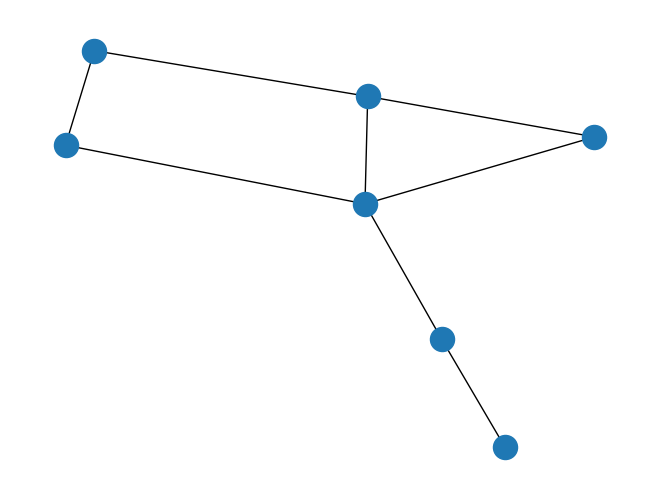

In [15]:
# As you can see, the Loss for each graph keeps decreasing across epochs, indicating that the training routine is working correctly.

# Results
# Let’s see how to use the optimized RNN as an initializer for the angles in the QAOA algorithm.

# First, we pick a new graph, not present in the training dataset:

new_graph = nx.gnp_random_graph(7, p=3 / 7)
new_cost = qaoa_from_graph(new_graph)

nx.draw(new_graph)

In [16]:
# Then we apply the trained RNN to this new graph, saving intermediate results coming from all the recurrent iterations in the network.

# Apply the RNN (be sure that training was performed)
res = recurrent_loop(new_cost, intermediate_steps=True)

# Extract all angle suggestions
start_zeros = tf.zeros(shape=(2 * n_layers, 1))
guess_0 = res[0]
guess_1 = res[1]
guess_2 = res[2]
guess_3 = res[3]
guess_4 = res[4]
final_loss = res[5]

# Wrap them into a list
guesses = [start_zeros, guess_0, guess_1, guess_2, guess_3, guess_4]

# Losses from the hybrid LSTM model
lstm_losses = [new_cost(tf.reshape(guess, shape=(2, n_layers))) for guess in guesses]

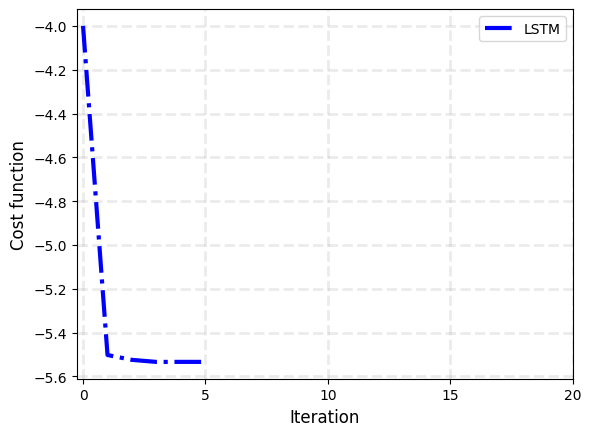

In [17]:
# Plot of the loss function

# We can plot these losses to see how well the RNN proposes new guesses for the parameters.
 
fig, ax = plt.subplots()

plt.plot(lstm_losses, color="blue", lw=3, ls="-.", label="LSTM")

plt.grid(ls="--", lw=2, alpha=0.25)
plt.ylabel("Cost function", fontsize=12)
plt.xlabel("Iteration", fontsize=12)
plt.legend()
ax.set_xticks([0, 5, 10, 15, 20]);
plt.show()

That’s remarkable! The RNN learned to propose new parameters such that the MaxCut cost is minimized very rapidly: in just a few iterations the loss reaches a minimum. Actually, it takes just a single step for the LSTM to find a very good minimum. In fact, due to the recurrent loop, the loss in each time step is directly dependent on the previous ones, with the first iteration thus having a lot of influence on the loss function defined above. Changing the loss function, for example giving less importance to initial steps and just focusing on the last one, leads to different optimization behaviors, but with the same final results.

Comparison with standard Stochastic Gradient Descent (SGD)

How well does this method compare with standard optimization techniques, for example, leveraging Stochastic Gradient Descent (SGD) to optimize the parameters in the QAOA?

Let’s check it out.

In [18]:
# Parameters are randomly initialized
x = tf.Variable(np.random.rand(2, 1))

# We set the optimizer to be a Stochastic Gradient Descent
opt = tf.keras.optimizers.SGD(learning_rate=0.01)
step = 15

# Training process
steps = []
sdg_losses = []
for _ in range(step):
    with tf.GradientTape() as tape:
        loss = new_cost(x)

    steps.append(x)
    sdg_losses.append(loss)

    gradients = tape.gradient(loss, [x])
    opt.apply_gradients(zip(gradients, [x]))
    print(f"Step {_+1} - Loss = {loss}")

print(f"Final cost function: {new_cost(x).numpy()}\nOptimized angles: {x.numpy()}")

Step 1 - Loss = -3.6881302516070504
Step 2 - Loss = -4.136528715338831
Step 3 - Loss = -4.558309871254487
Step 4 - Loss = -4.903187356948457
Step 5 - Loss = -5.151115255700594
Step 6 - Loss = -5.311868985969246
Step 7 - Loss = -5.408812455764015
Step 8 - Loss = -5.464724534511862
Step 9 - Loss = -5.496246306216674
Step 10 - Loss = -5.513909563399687
Step 11 - Loss = -5.523884478507887
Step 12 - Loss = -5.52963720896139
Step 13 - Loss = -5.533071676661001
Step 14 - Loss = -5.5352221750823905
Step 15 - Loss = -5.536648486760109
Final cost function: -5.537654195388624
Optimized angles: [[ 0.64124211]
 [-0.36194874]]


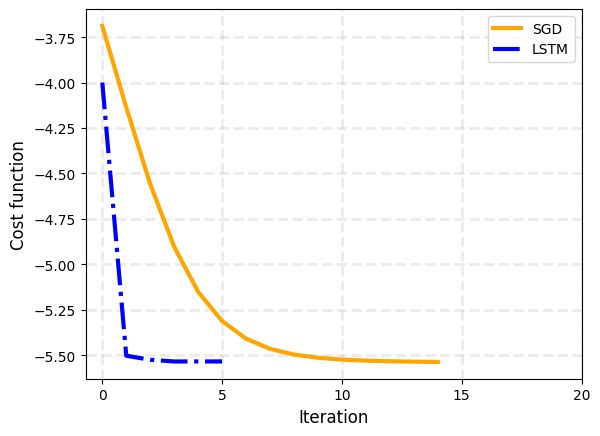

In [19]:
fig, ax = plt.subplots()

plt.plot(sdg_losses, color="orange", lw=3, label="SGD")

plt.plot(lstm_losses, color="blue", lw=3, ls="-.", label="LSTM")

plt.grid(ls="--", lw=2, alpha=0.25)
plt.legend()
plt.ylabel("Cost function", fontsize=12)
plt.xlabel("Iteration", fontsize=12)
ax.set_xticks([0, 5, 10, 15, 20]);
plt.show()

Hurray! 🎉🎉

As is clear from the picture, the RNN reaches a better minimum in fewer iterations than the standard SGD. Thus, as the authors suggest, the trained RNN can be used for a few iterations at the start of the training procedure to initialize the parameters of the quantum circuit close to an optimal solution. Then, a standard optimizer like the SGD can be used to fine-tune the proposed parameters and reach even better solutions. While on this small scale example the benefits of using an LSTM to initialize parameters may seem modest, on more complicated instances and problems it can make a big difference, since, on random initialization of the parameters, standard local optimizer may encounter problems finding a good minimization direction (for further details, see 1, 2).

